In [52]:
#!pip3 install  lime keras_tuner
#!pip3 install tensorflow
#!pip3 install pydot graphviz

In [57]:
import pydot
import graphviz

In [48]:
%load_ext autoreload
%autoreload 2

In [9]:
## Packages Dependencies
import os
import shutil
import numpy as np
import nltk
from nltk.corpus import names
import random

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 150
    
from lime.lime_text import LimeTextExplainer

import tensorflow
import tensorflow.keras as keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
    # from keras.layers import Dense
    # from keras.layers import LSTM, RNN, GRU
    # from keras.layers import Embedding
    # from keras.layers import SpatialDropout1D

import keras_tuner

2024-02-18 14:30:40.352276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
nltk.download('names')

[nltk_data] Downloading package names to /Users/yohan/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

In [13]:
labeled_names = ([(name, 1) for name in names.words('male.txt')] +
                 [(name, 0) for name in names.words('female.txt')])
random.shuffle(labeled_names)


In [16]:
labeled_names[1:5]

[('Stanislaw', 1), ('Jacklyn', 0), ('Charis', 0), ('Taffy', 0)]

In [17]:
train_set, test_set = train_test_split(labeled_names,
                                       test_size=0.2,
                                       random_state=42)
print(len(train_set), len(test_set))


6355 1589


In [19]:
train_set[1:5]

[('Stefanie', 0), ('Joslyn', 0), ('Jean-Pierre', 1), ('Nerissa', 0)]

In [20]:
names = [n for (n, l) in train_set] ## X
labels = [l for (n, l) in train_set] ## y

In [21]:
len(names)

6355

In [37]:
### Approach - 1 - Text to Seq
#### Develop the dictionary mapping for Top n words/character using Tokenizer
#### Based on the dictionary, define a fixed length word integer sequence. Do padding as required
#### Use the word integer sequence to build the embedding using NN/RNN 

In [22]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(names) ## similar to CountVectorizer.fit_transform()

In [23]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 30


In [24]:
tokenizer.word_index


{'e': 1,
 'a': 2,
 'i': 3,
 'n': 4,
 'r': 5,
 'l': 6,
 'o': 7,
 't': 8,
 's': 9,
 'd': 10,
 'y': 11,
 'm': 12,
 'h': 13,
 'c': 14,
 'b': 15,
 'u': 16,
 'g': 17,
 'k': 18,
 'j': 19,
 'v': 20,
 'f': 21,
 'p': 22,
 'w': 23,
 'z': 24,
 'x': 25,
 'q': 26,
 '-': 27,
 ' ': 28,
 "'": 29}

In [25]:
names_ints = tokenizer.texts_to_sequences(names)
print(names[:5])
print(names_ints[:5])
print(labels[:5])

['Gabbey', 'Stefanie', 'Joslyn', 'Jean-Pierre', 'Nerissa']
[[17, 2, 15, 15, 1, 11], [9, 8, 1, 21, 2, 4, 3, 1], [19, 7, 9, 6, 11, 4], [19, 1, 2, 4, 27, 22, 3, 1, 5, 5, 1], [4, 1, 5, 3, 9, 9, 2]]
[0, 0, 0, 1, 0]


Helen-Elizabeth


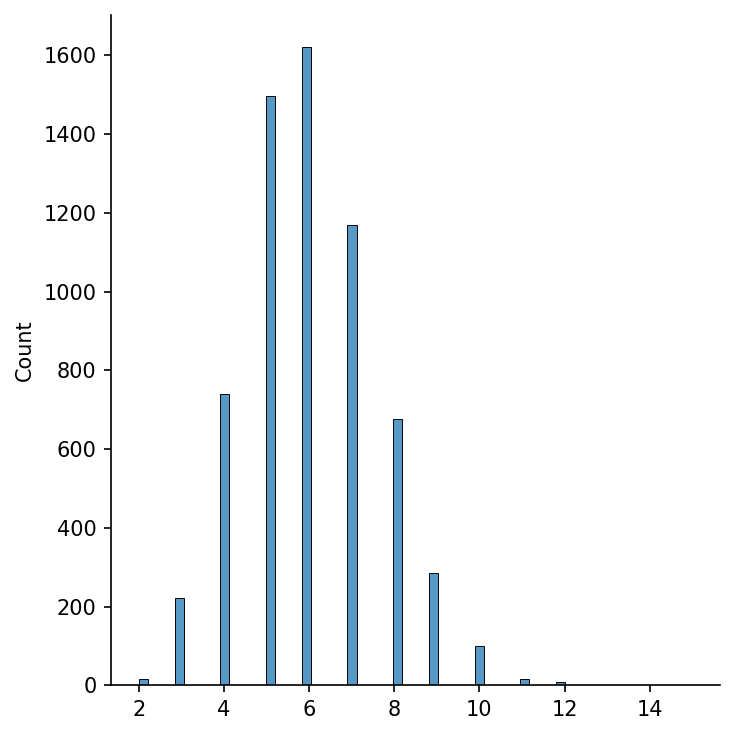

In [26]:
## We can check the length distribution of texts in corpus

names_lens = [len(n) for n in names_ints]
names_lens

sns.displot(names_lens)
print(names[np.argmax(names_lens)])  # longest name


In [27]:
max_len = names_lens[np.argmax(names_lens)]
max_len

15

In [28]:
names_ints_pad = sequence.pad_sequences(names_ints, maxlen=max_len)
names_ints_pad[:10]


array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0, 17,  2, 15, 15,  1, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  8,  1, 21,  2,  4,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 19,  7,  9,  6, 11,  4],
       [ 0,  0,  0,  0, 19,  1,  2,  4, 27, 22,  3,  1,  5,  5,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  1,  5,  3,  9,  9,  2],
       [ 0,  0,  0,  0,  0, 14,  5,  3,  9,  8,  7, 22, 13,  1,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  2,  4, 14, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  5,  7,  9,  2,  6,  1,  1,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2, 15, 15, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  1, 20, 20, 11]],
      dtype=int32)

In [31]:
## training data
X_train = np.array(names_ints_pad).astype('int32')
y_train = np.array(labels)


## testing data
X_test_texts = [n for (n, l) in test_set]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen=max_len)).astype('int32')
y_test = np.array([l for (n, l) in test_set])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6355, 15)
(6355,)
(1589, 15)
(1589,)


In [ ]:
### Approach 2: Bag of Word
#### Develop a Bag of Matrix using tfifd approach or relevant
#### 

In [38]:
names_matrix = tokenizer.texts_to_matrix(names, mode="binary")
print(names_matrix.shape)

(6355, 30)


In [39]:
print(names[2])
print(names_matrix[2,:])


Joslyn
[0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [40]:
tokenizer.word_index

{'e': 1,
 'a': 2,
 'i': 3,
 'n': 4,
 'r': 5,
 'l': 6,
 'o': 7,
 't': 8,
 's': 9,
 'd': 10,
 'y': 11,
 'm': 12,
 'h': 13,
 'c': 14,
 'b': 15,
 'u': 16,
 'g': 17,
 'k': 18,
 'j': 19,
 'v': 20,
 'f': 21,
 'p': 22,
 'w': 23,
 'z': 24,
 'x': 25,
 'q': 26,
 '-': 27,
 ' ': 28,
 "'": 29}

In [42]:
X_train2 = np.array(names_matrix).astype('int32')
y_train2 = np.array(labels)

X_test2 = tokenizer.texts_to_matrix(X_test_texts,mode="binary").astype('int32')
y_test2 = np.array([l for (n, l) in test_set])

print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)


(6355, 30)
(6355,)
(1589, 30)
(1589,)

(6355, 30)
(6355,)
(1589, 30)
(1589,)


(1589,)

In [49]:
# Two Versions of Plotting Functions for `history` from `model.fit()`
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()


In [55]:
## Define Model
model1 = keras.Sequential()
model1.add(keras.Input(shape=(vocab_size, ), name="one_hot_input"))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model1.add(layers.Dense(1, activation="sigmoid", name="output"))

## Compile Model
model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])



In [58]:
plot_model(model1, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
## Hyperparameters
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.2

In [60]:
## Fit the model
history1 = model1.fit(X_train2,
                      y_train2,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/20
40/40 - 5s - loss: 0.6666 - accuracy: 0.6277 - val_loss: 0.6468 - val_accuracy: 0.6491 - 5s/epoch - 123ms/step
Epoch 2/20
40/40 - 0s - loss: 0.6446 - accuracy: 0.6367 - val_loss: 0.6244 - val_accuracy: 0.6640 - 497ms/epoch - 12ms/step
Epoch 3/20
40/40 - 1s - loss: 0.6241 - accuracy: 0.6613 - val_loss: 0.6031 - val_accuracy: 0.6924 - 689ms/epoch - 17ms/step
Epoch 4/20
40/40 - 1s - loss: 0.6045 - accuracy: 0.6835 - val_loss: 0.5881 - val_accuracy: 0.7002 - 1s/epoch - 26ms/step
Epoch 5/20
40/40 - 1s - loss: 0.5910 - accuracy: 0.6967 - val_loss: 0.5779 - val_accuracy: 0.7026 - 762ms/epoch - 19ms/step
Epoch 6/20
40/40 - 1s - loss: 0.5828 - accuracy: 0.7038 - val_loss: 0.5735 - val_accuracy: 0.7002 - 612ms/epoch - 15ms/step
Epoch 7/20
40/40 - 1s - loss: 0.5778 - accuracy: 0.7010 - val_loss: 0.5758 - val_accuracy: 0.6994 - 571ms/epoch - 14ms/step
Epoch 8/20
40/40 - 1s - loss: 0.5745 - accuracy: 0.7071 - val_loss: 0.5707 - val_accuracy: 0.7034 - 763ms/epoch - 19ms/step
Epoch 9/20
40

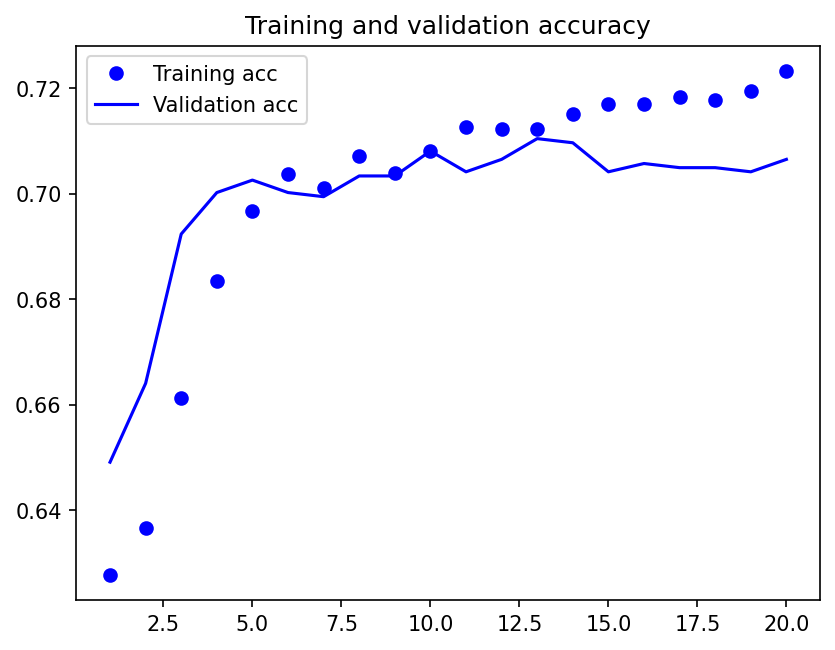

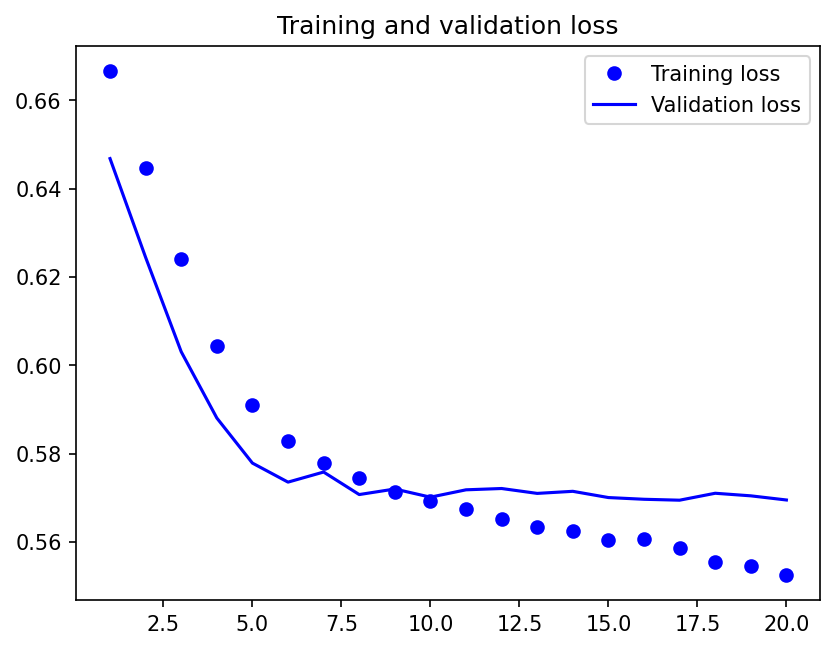

In [61]:
plot1(history1)

In [62]:
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

13/13 - 0s - loss: 0.5608 - accuracy: 0.7275 - 413ms/epoch - 32ms/step


[0.5607766509056091, 0.7275015711784363]

In [65]:
### RNN with Embedding

In [64]:
## Define the embedding dimension
EMBEDDING_DIM = 128

## Define model
model2 = Sequential()
model2.add(
    layers.Embedding(input_dim=vocab_size,
                     output_dim=EMBEDDING_DIM,
                     input_length=max_len,
                     mask_zero=True))
model2.add(layers.SimpleRNN(16, activation="relu", name="RNN_layer"))
model2.add(layers.Dense(16, activation="relu", name="dense_layer"))
model2.add(layers.Dense(1, activation="sigmoid", name="output"))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

In [66]:
history2 = model2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)


Epoch 1/20
40/40 - 8s - loss: 0.6492 - accuracy: 0.7073 - val_loss: 0.5672 - val_accuracy: 0.7223 - 8s/epoch - 210ms/step
Epoch 2/20
40/40 - 1s - loss: 0.5031 - accuracy: 0.7490 - val_loss: 0.4567 - val_accuracy: 0.7805 - 978ms/epoch - 24ms/step
Epoch 3/20
40/40 - 1s - loss: 0.4413 - accuracy: 0.7850 - val_loss: 0.4386 - val_accuracy: 0.7836 - 1s/epoch - 29ms/step
Epoch 4/20
40/40 - 1s - loss: 0.4220 - accuracy: 0.7931 - val_loss: 0.4279 - val_accuracy: 0.7915 - 754ms/epoch - 19ms/step
Epoch 5/20
40/40 - 1s - loss: 0.4108 - accuracy: 0.8011 - val_loss: 0.4246 - val_accuracy: 0.7954 - 904ms/epoch - 23ms/step
Epoch 6/20
40/40 - 1s - loss: 0.4027 - accuracy: 0.8086 - val_loss: 0.4215 - val_accuracy: 0.7962 - 860ms/epoch - 21ms/step
Epoch 7/20
40/40 - 1s - loss: 0.3944 - accuracy: 0.8125 - val_loss: 0.4184 - val_accuracy: 0.8009 - 859ms/epoch - 21ms/step
Epoch 8/20
40/40 - 1s - loss: 0.3882 - accuracy: 0.8202 - val_loss: 0.4185 - val_accuracy: 0.7946 - 890ms/epoch - 22ms/step
Epoch 9/20
40

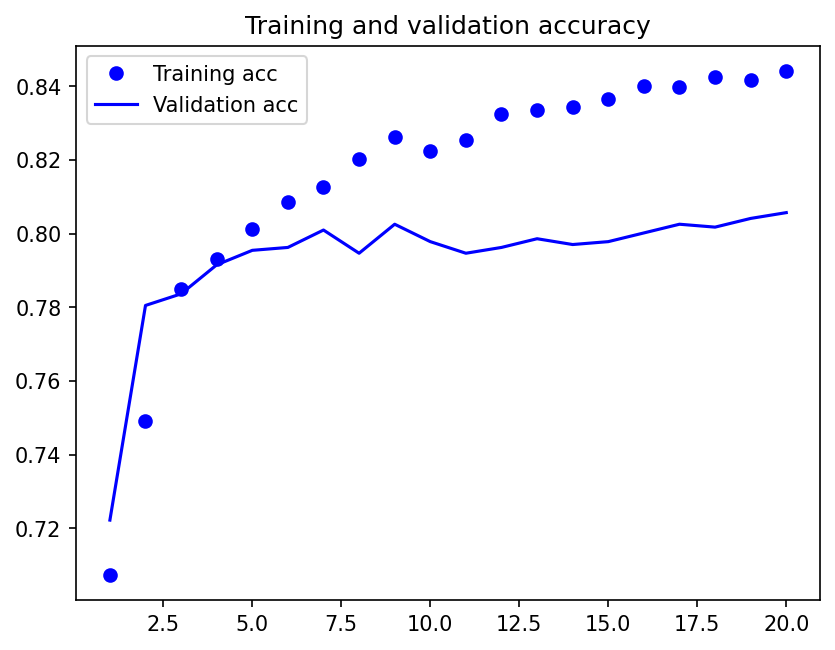

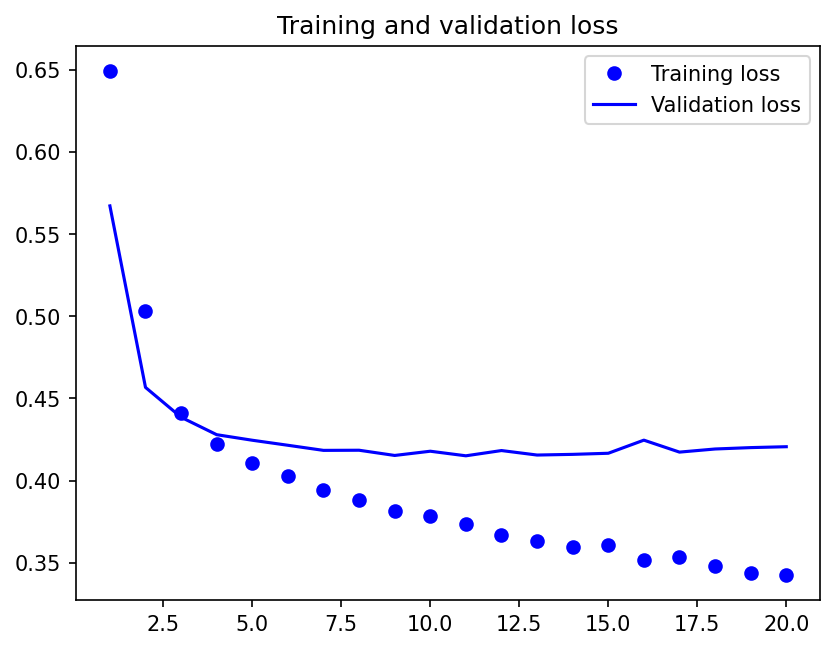

In [67]:
plot1(history2)

In [ ]:
### Handling overfit and regularisation

In [68]:
## Define embedding dimension
EMBEDDING_DIM = 128

## Define model
model3 = Sequential()
model3.add(
    layers.Embedding(input_dim=vocab_size,
                     output_dim=EMBEDDING_DIM,
                     input_length=max_len,
                     mask_zero=True))
model3.add(
    layers.SimpleRNN(16,
                     activation="relu",
                     name="RNN_layer",
                     dropout=0.2, ## dropout for input character
                     recurrent_dropout=0.2))  ## dropout for previous state
model3.add(layers.Dense(16, activation="relu", name="dense_layer"))
model3.add(layers.Dense(1, activation="sigmoid", name="output"))

model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

In [69]:
plot_model(model3, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [70]:
history3 = model3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)


Epoch 1/20
40/40 - 10s - loss: 0.6130 - accuracy: 0.6310 - val_loss: 0.5361 - val_accuracy: 0.6735 - 10s/epoch - 253ms/step
Epoch 2/20
40/40 - 1s - loss: 0.5148 - accuracy: 0.7197 - val_loss: 0.4724 - val_accuracy: 0.7726 - 935ms/epoch - 23ms/step
Epoch 3/20
40/40 - 1s - loss: 0.4690 - accuracy: 0.7716 - val_loss: 0.4467 - val_accuracy: 0.7828 - 903ms/epoch - 23ms/step
Epoch 4/20
40/40 - 1s - loss: 0.4523 - accuracy: 0.7775 - val_loss: 0.4400 - val_accuracy: 0.7758 - 817ms/epoch - 20ms/step
Epoch 5/20
40/40 - 1s - loss: 0.4401 - accuracy: 0.7836 - val_loss: 0.4379 - val_accuracy: 0.7844 - 875ms/epoch - 22ms/step
Epoch 6/20
40/40 - 1s - loss: 0.4379 - accuracy: 0.7876 - val_loss: 0.4349 - val_accuracy: 0.7828 - 842ms/epoch - 21ms/step
Epoch 7/20
40/40 - 2s - loss: 0.4344 - accuracy: 0.7876 - val_loss: 0.4289 - val_accuracy: 0.7884 - 2s/epoch - 49ms/step
Epoch 8/20
40/40 - 2s - loss: 0.4306 - accuracy: 0.7880 - val_loss: 0.4315 - val_accuracy: 0.7789 - 2s/epoch - 41ms/step
Epoch 9/20
40/

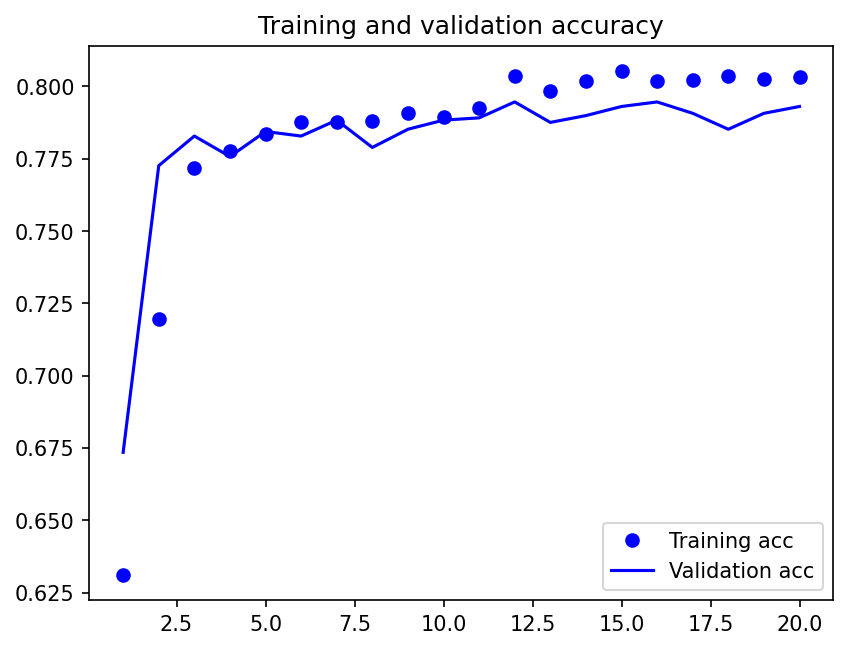

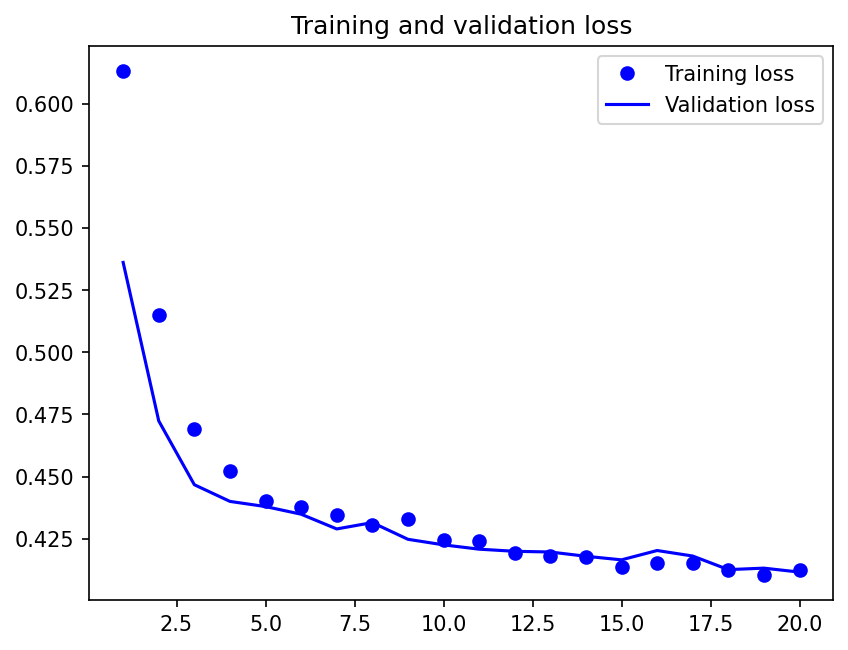

In [71]:
plot1(history3)

In [72]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)


13/13 - 0s - loss: 0.4237 - accuracy: 0.8024 - 291ms/epoch - 22ms/step


[0.423656165599823, 0.8023914694786072]

In [73]:
### Stacking the recurring network

In [74]:
## Define embedding dimension
EMBEDDING_DIM = 128

## Define model
model4 = Sequential()
model4.add(
    layers.Embedding(input_dim=vocab_size,
                     output_dim=EMBEDDING_DIM,
                     input_length=max_len,
                     mask_zero=True))
model4.add(
    layers.SimpleRNN(16,
                     activation="relu",
                     name="RNN_layer_1",
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences=True) 
)  ## To ensure the hidden states of all timesteps are passed down to next layer
model4.add(
    layers.SimpleRNN(16,
                     activation="relu",
                     name="RNN_layer_2",
                     dropout=0.2,
                     recurrent_dropout=0.2))
model4.add(layers.Dense(1, activation="sigmoid", name="output"))

## Compile model
model4.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

In [75]:
history4 = model4.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)


Epoch 1/20
40/40 - 18s - loss: 0.6386 - accuracy: 0.6314 - val_loss: 0.5718 - val_accuracy: 0.6538 - 18s/epoch - 449ms/step
Epoch 2/20
40/40 - 2s - loss: 0.5581 - accuracy: 0.6458 - val_loss: 0.5028 - val_accuracy: 0.7207 - 2s/epoch - 57ms/step
Epoch 3/20
40/40 - 1s - loss: 0.5139 - accuracy: 0.7083 - val_loss: 0.4771 - val_accuracy: 0.7773 - 1s/epoch - 34ms/step
Epoch 4/20
40/40 - 1s - loss: 0.4919 - accuracy: 0.7496 - val_loss: 0.4670 - val_accuracy: 0.7695 - 1s/epoch - 36ms/step
Epoch 5/20
40/40 - 1s - loss: 0.4811 - accuracy: 0.7626 - val_loss: 0.4532 - val_accuracy: 0.7813 - 1s/epoch - 29ms/step
Epoch 6/20
40/40 - 1s - loss: 0.4613 - accuracy: 0.7705 - val_loss: 0.4407 - val_accuracy: 0.7789 - 825ms/epoch - 21ms/step
Epoch 7/20
40/40 - 1s - loss: 0.4508 - accuracy: 0.7756 - val_loss: 0.4355 - val_accuracy: 0.7813 - 998ms/epoch - 25ms/step
Epoch 8/20
40/40 - 1s - loss: 0.4422 - accuracy: 0.7797 - val_loss: 0.4327 - val_accuracy: 0.7813 - 1s/epoch - 26ms/step
Epoch 9/20
40/40 - 1s -

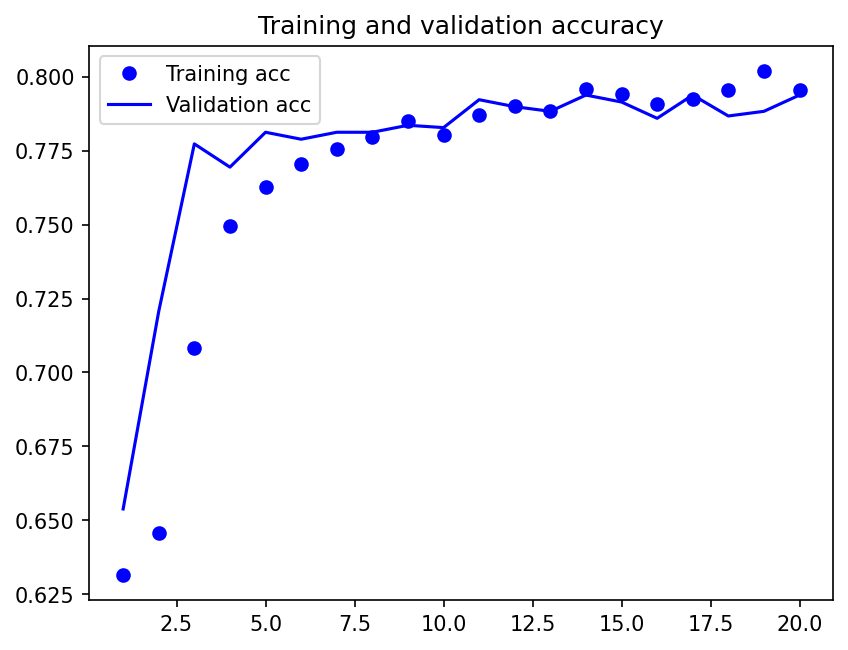

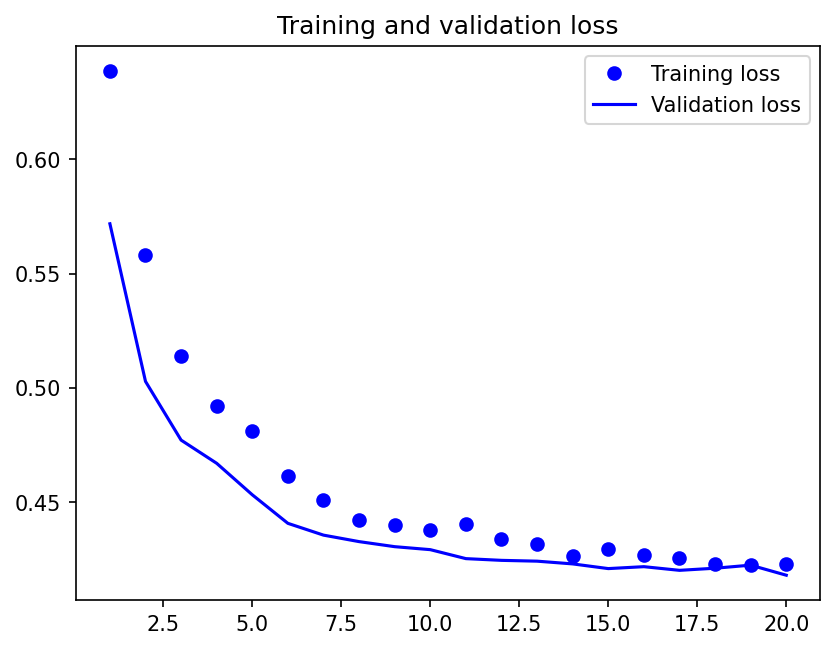

In [76]:
plot1(history4)

In [77]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

13/13 - 0s - loss: 0.4262 - accuracy: 0.7999 - 323ms/epoch - 25ms/step


[0.4262119233608246, 0.7998741269111633]

In [78]:
### Leveraging Bidirectional learning and advanced RNN models LSTM/GRU

In [79]:
## Define embedding dimension
EMBEDDING_DIM = 128

## Define model
model5 = Sequential()
model5.add(
    layers.Embedding(input_dim=vocab_size,
                      output_dim=EMBEDDING_DIM,
                      input_length=max_len,
                      mask_zero=True))
model5.add(
    layers.Bidirectional(  ## Bidirectional sequence processing
        layers.LSTM(32,
                    activation="relu",
                    name="lstm_layer_1",
                    dropout=0.2,
                    recurrent_dropout=0.5,
                    return_sequences=True)))
model5.add(
    layers.Bidirectional(  ## Bidirectional sequence processing
        layers.LSTM(32,
                    activation="relu",
                    name="lstm_layer_2",
                    dropout=0.2,
                    recurrent_dropout=0.5)))
model5.add(layers.Dense(1, activation="sigmoid", name="output"))

model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

In [80]:
plot_model(model5, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [81]:
history5 = model5.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)



Epoch 1/20
40/40 - 45s - loss: 0.6519 - accuracy: 0.6314 - val_loss: 0.6013 - val_accuracy: 0.6483 - 45s/epoch - 1s/step
Epoch 2/20
40/40 - 6s - loss: 0.5807 - accuracy: 0.6493 - val_loss: 0.5382 - val_accuracy: 0.7175 - 6s/epoch - 150ms/step
Epoch 3/20
40/40 - 9s - loss: 0.5087 - accuracy: 0.7433 - val_loss: 0.4943 - val_accuracy: 0.7553 - 9s/epoch - 236ms/step
Epoch 4/20
40/40 - 13s - loss: 0.4607 - accuracy: 0.7762 - val_loss: 0.4876 - val_accuracy: 0.7569 - 13s/epoch - 319ms/step
Epoch 5/20
40/40 - 11s - loss: 0.4446 - accuracy: 0.7848 - val_loss: 0.4790 - val_accuracy: 0.7718 - 11s/epoch - 265ms/step
Epoch 6/20
40/40 - 12s - loss: 0.4304 - accuracy: 0.7872 - val_loss: 0.4654 - val_accuracy: 0.7750 - 12s/epoch - 290ms/step
Epoch 7/20
40/40 - 10s - loss: 0.4249 - accuracy: 0.7927 - val_loss: 0.4554 - val_accuracy: 0.7805 - 10s/epoch - 250ms/step
Epoch 8/20
40/40 - 16s - loss: 0.4213 - accuracy: 0.7962 - val_loss: 0.4476 - val_accuracy: 0.7750 - 16s/epoch - 395ms/step
Epoch 9/20
40/4

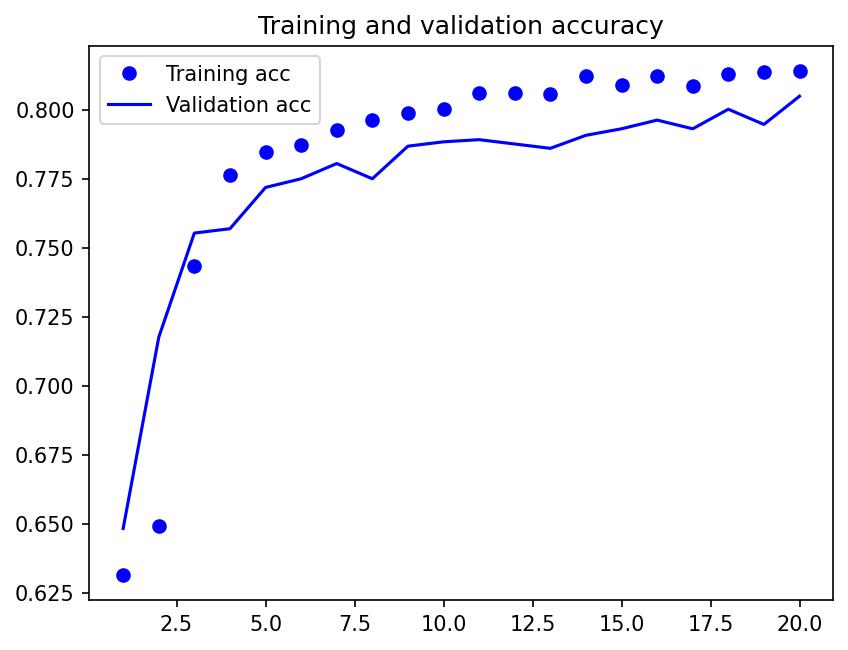

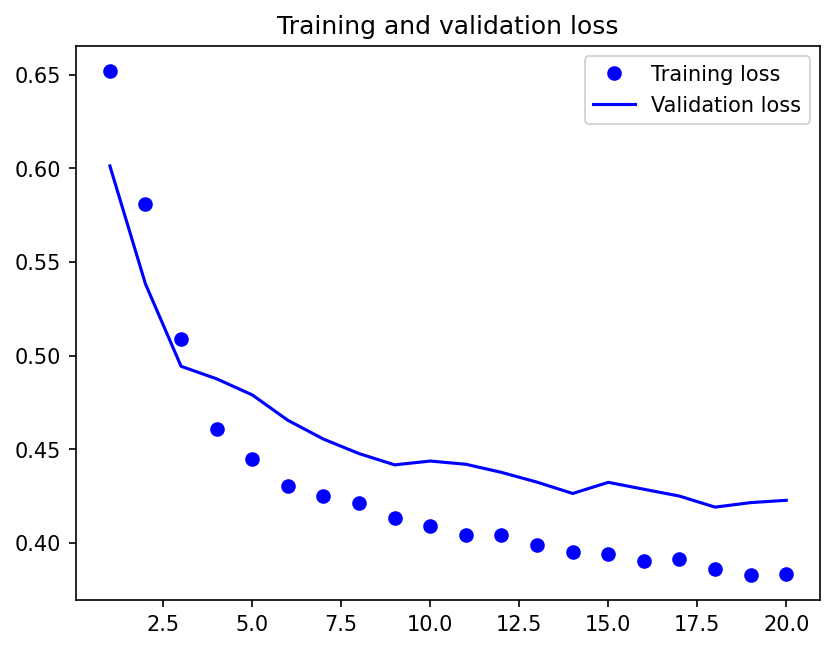

In [82]:
plot1(history5)

In [83]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)


13/13 - 0s - loss: 0.4251 - accuracy: 0.7999 - 309ms/epoch - 24ms/step


[0.42510202527046204, 0.7998741269111633]

In [84]:
### Visualzing the Embedding using t-sne 

In [85]:
## A name in sequence from test set
print(X_test_texts[10])
print(X_test[10])


Genni
[ 0  0  0  0  0  0  0  0  0  0 17  1  4  4  3]


In [86]:
## Extract Corpus Dictionary (mapping of chars and integer indices)
ind2char = tokenizer.index_word
[ind2char.get(i) for i in X_test[10] if ind2char.get(i) != None]


['g', 'e', 'n', 'n', 'i']

In [87]:
## Extract the embedding layer (its weights matrix)
char_vectors = model5.layers[0].get_weights()[0]
print(char_vectors.shape) ## embedding shape (vocab_size, embed_dim)
print(char_vectors[1,:]) ## first char embeddings


(30, 128)
[-0.10410247  0.03078314 -0.07490637 -0.0311057   0.04462703  0.13727868
  0.06513598 -0.01495533 -0.06515859 -0.01526271  0.0216424   0.02953256
  0.00897471 -0.00537729  0.01972051 -0.10201332 -0.00768891  0.00092885
 -0.10248294 -0.06507371  0.07018548 -0.02726445  0.08234884 -0.05087384
  0.0600021   0.082693   -0.07682173 -0.02315906 -0.09298311  0.00318061
  0.01768338  0.00794053  0.04667043 -0.06832489  0.09090397  0.06608182
  0.07208987  0.06216376 -0.00975283  0.08058243  0.09863356 -0.0463414
 -0.01318382 -0.01045835  0.00901616  0.07598609  0.05751058 -0.00961077
  0.07527535  0.05504902  0.00404456  0.06052728  0.03800699 -0.08058291
 -0.04932085 -0.09008134  0.0272315   0.09671284  0.00642138 -0.09576868
  0.01130418 -0.08147784  0.03970761 -0.07378694  0.04719856  0.06439445
  0.0240486  -0.0516613  -0.11878783  0.06003675  0.05629214  0.03609047
 -0.00596163  0.02428558  0.04350045  0.03782416  0.06293713 -0.02000021
  0.04867784 -0.09420226 -0.06101573 -0.06

In [88]:
labels = [char for (ind, char) in tokenizer.index_word.items()]
labels.insert(0, None)
labels

[None,
 'e',
 'a',
 'i',
 'n',
 'r',
 'l',
 'o',
 't',
 's',
 'd',
 'y',
 'm',
 'h',
 'c',
 'b',
 'u',
 'g',
 'k',
 'j',
 'v',
 'f',
 'p',
 'w',
 'z',
 'x',
 'q',
 '-',
 ' ',
 "'"]

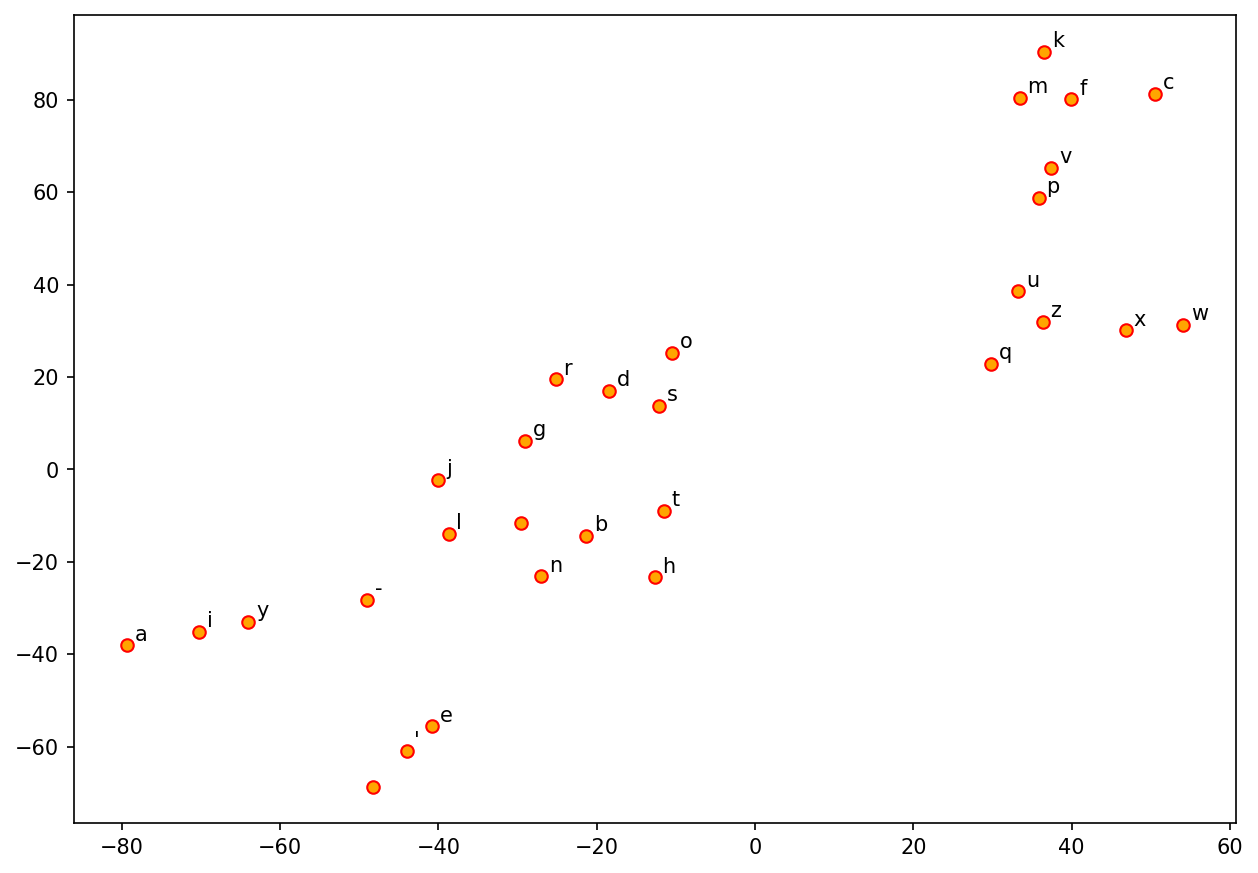

In [89]:
## Visulizing char embeddings via dimensional reduction techniques

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)

T = tsne.fit_transform(char_vectors)
labels = labels

plt.figure(figsize=(10, 7), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

In [90]:
### finetuning the embedding using keras-tuner

In [91]:
## wrap model definition and compiling

def build_model(hp):
    m = Sequential()
    m.add(
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=hp.Int(
                'output_dim',  ## tuning 2
                min_value=32,
                max_value=128,
                step=32),
            input_length=max_len,
            mask_zero=True))
    m.add(
        layers.Bidirectional(
            layers.LSTM(
                hp.Int('units', min_value=16, max_value=64,
                       step=16),  ## tuning 1
                activation="relu",
                dropout=0.2,
                recurrent_dropout=0.2)))
    m.add(layers.Dense(1, activation="sigmoid", name="output"))

    m.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])
    return m


In [92]:
## This is to clean up the temp dir from the tuner
## Every time we re-start the tunner, it's better to keep the temp dir clean

if os.path.isdir('my_dir'):
    shutil.rmtree('my_dir')

In [93]:
tuner = keras_tuner.RandomSearch(build_model,
                                       objective='val_accuracy',
                                       max_trials=10,
                                       executions_per_trial=2,
                                       directory='my_dir')

In [94]:
## Check the tuner's search space
tuner.search_space_summary()


Search space summary
Default search space size: 2
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}


In [95]:
%%time
## Start tuning with the tuner
tuner.search(X_train, y_train, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE)


Trial 10 Complete [00h 00m 37s]
val_accuracy: 0.6487017869949341

Best val_accuracy So Far: 0.650668740272522
Total elapsed time: 00h 09m 30s
CPU times: user 6min 19s, sys: 29.5 s, total: 6min 49s
Wall time: 9min 30s


In [96]:
## Retrieve the best models from the tuner
models = tuner.get_best_models(num_models=2)


In [97]:
plot_model(models[0], show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [98]:
## Retrieve the summary of results from the tuner
tuner.results_summary()


Results summary
Results in my_dir/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
output_dim: 64
units: 64
Score: 0.650668740272522

Trial 07 summary
Hyperparameters:
output_dim: 96
units: 48
Score: 0.650668740272522

Trial 05 summary
Hyperparameters:
output_dim: 128
units: 32
Score: 0.6498819589614868

Trial 09 summary
Hyperparameters:
output_dim: 128
units: 16
Score: 0.6487017869949341

Trial 00 summary
Hyperparameters:
output_dim: 96
units: 32
Score: 0.6483083963394165

Trial 02 summary
Hyperparameters:
output_dim: 64
units: 48
Score: 0.6483083963394165

Trial 03 summary
Hyperparameters:
output_dim: 32
units: 32
Score: 0.6483083963394165

Trial 04 summary
Hyperparameters:
output_dim: 64
units: 16
Score: 0.6483083963394165

Trial 06 summary
Hyperparameters:
output_dim: 32
units: 16
Score: 0.6483083963394165

Trial 08 summary
Hyperparameters:
output_dim: 64
units: 32
Score: 0.6483083963394165


In [99]:
### Train the model based on keras-tuner output
EMBEDDING_DIM = 128
HIDDEN_STATE=32
model6 = Sequential()
model6.add(
    layers.Embedding(input_dim=vocab_size,
                     output_dim=EMBEDDING_DIM,
                     input_length=max_len,
                     mask_zero=True))
model6.add(
    layers.Bidirectional(
        layers.LSTM(HIDDEN_STATE,
                    activation="relu",
                    name="lstm_layer",
                    dropout=0.2,
                    recurrent_dropout=0.5)))
model6.add(layers.Dense(1, activation="sigmoid", name="output"))

model6.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
plot_model(model6)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [100]:
history6 = model6.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)


Epoch 1/20
40/40 - 16s - loss: 0.6525 - accuracy: 0.6310 - val_loss: 0.6012 - val_accuracy: 0.6499 - 16s/epoch - 398ms/step
Epoch 2/20
40/40 - 4s - loss: 0.5614 - accuracy: 0.6890 - val_loss: 0.4974 - val_accuracy: 0.7537 - 4s/epoch - 92ms/step
Epoch 3/20
40/40 - 4s - loss: 0.4634 - accuracy: 0.7746 - val_loss: 0.4658 - val_accuracy: 0.7710 - 4s/epoch - 97ms/step
Epoch 4/20
40/40 - 4s - loss: 0.4334 - accuracy: 0.7921 - val_loss: 0.4542 - val_accuracy: 0.7781 - 4s/epoch - 110ms/step
Epoch 5/20
40/40 - 4s - loss: 0.4239 - accuracy: 0.7974 - val_loss: 0.4441 - val_accuracy: 0.7884 - 4s/epoch - 91ms/step
Epoch 6/20
40/40 - 4s - loss: 0.4177 - accuracy: 0.7994 - val_loss: 0.4418 - val_accuracy: 0.7860 - 4s/epoch - 92ms/step
Epoch 7/20
40/40 - 4s - loss: 0.4119 - accuracy: 0.8021 - val_loss: 0.4482 - val_accuracy: 0.7899 - 4s/epoch - 92ms/step
Epoch 8/20
40/40 - 4s - loss: 0.4068 - accuracy: 0.8055 - val_loss: 0.4436 - val_accuracy: 0.7907 - 4s/epoch - 94ms/step
Epoch 9/20
40/40 - 4s - loss

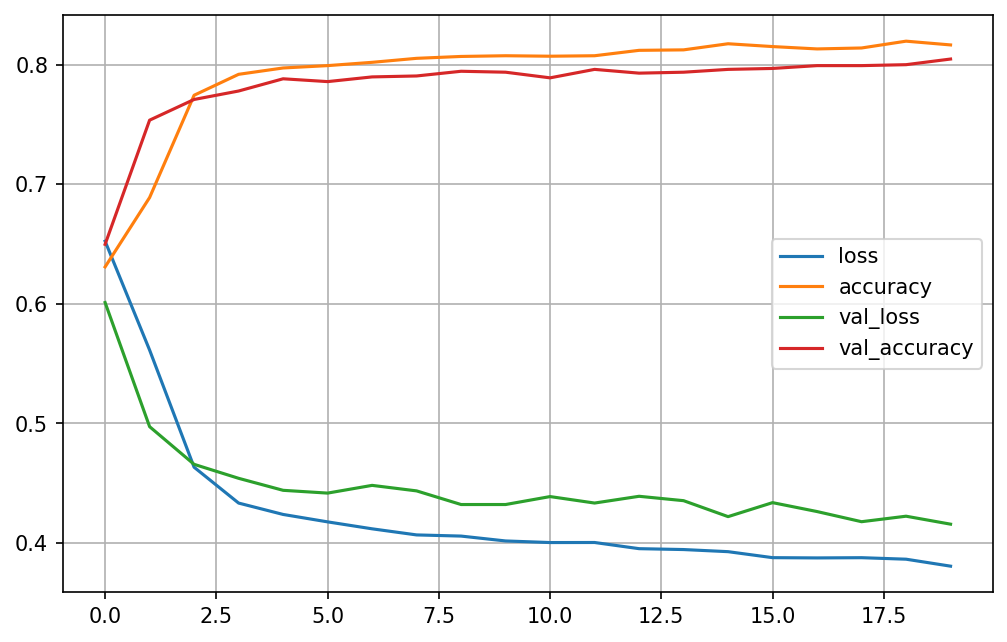

In [101]:
plot2(history6)

In [102]:
### Testing the output and explain

In [103]:
explainer = LimeTextExplainer(class_names=['female','male'], char_level=True)


In [104]:
def model_predict_pipeline(text_list):
    ## text_list: a list of training tokens (1d)
    ## output: a [d, k] array, d = number of input strings; k = 2 (probs of the two classes)
    ## Note: To use `explainer.explain_instance`, we need a predictor, which takes a LIST of tokens as input, and returns a list of (1-x, x) class probablities 
    _seq = tokenizer.texts_to_sequences(text_list) ## treat the entire string as one unit
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    _out_prob = model6.predict(_seq_pad)[:,0].tolist() ## predict() requires a 2d array as input and returns a 2D array
    return np.array([[float(1-x), float(x)] for x in _out_prob])
    #return model6.predict(np.array(_seq_pad))

In [105]:
text_id = 13
print(X_test_texts[text_id]) ## Suset of a specific string from a list
model_predict_pipeline([X_test_texts[text_id]]) ## Remember to convert STRING to LIST (length=1)

Adair
1/1 [==============================] - 1s 1s/step


array([[0.32934707, 0.67065293]])

In [106]:
exp = explainer.explain_instance(X_test_texts[text_id], ## requires a raw string
                                 model_predict_pipeline, ## reqires a predictor with list as input
                                 num_features=10,
                                 top_labels=1)


157/157 [==============================] - 1s 8ms/step


In [107]:
exp.show_in_notebook(text=True)